In [1]:
import numpy as np
import cupy as cp
from scipy.spatial.distance import cdist
from visualize import *

# Kernel
Kernel is defined as:
## $$ k(x,x')=e^{-\gamma_s {\lVert S(x)-S(x')\rVert}^2}e^{-\gamma_c {\lVert C(x)-C(x')\rVert}^2} $$

In [2]:
def computeKernel(X, gamma_s=0.025, gamma_c=0.025, H=100, W=100):
    # X: Nxk (N: #features = H * W, k: dimension of each feature)
    # output: Gram matrix K, NxN
    
    indices = np.transpose(np.indices((H, W), dtype=np.float), (1, 2, 0)).reshape(-1, 2)
    dist_s = cdist(indices, indices, 'sqeuclidean')
    dist_s /= np.max(dist_s)
    
    dist_c = cdist(X, X, 'sqeuclidean')
    
    return np.exp(-gamma_s * dist_s) * np.exp(-gamma_c * dist_c)

In [3]:
def readImg(filename='image1.png'):
    return plt.imread(filename).reshape(-1, 3).astype(np.float)

# K-means

In [4]:
def initKmeans(X, k, method='kmeans++'):
    # init means for k-means
    # X: data points, (N, d)
    # k: #clusters
    # return: initial means of shape (k, d), d is the dimension of data points
    
    N = X.shape[0] # #data points
    
    means = None
    
    if method == 'random pick':
        means = X[np.random.randint(N, size=k)]
    
    if method == 'random partition':
        # random partition (assign random labels)
        labels = np.random.randint(k, size=N)
        
        # calculate mean by those labels
        means = np.empty((k, X.shape[1]))
        for i in range(k):
            means[i] = np.mean(X[labels == i], axis=0)
    
    if method == 'equal split':
        labels = np.full(N, k - 1)
        for i in range(k):
            labels[(N // k) * i:(N // k) * (i + 1)] = i
        
        # calculate mean by those labels
        means = np.empty((k, X.shape[1]))
        for i in range(k):
            means[i] = np.mean(X[labels == i], axis=0)
    
    if method == 'kmeans++':
        # pick k points as initial means
        
        sqDist = cdist(X, X, 'sqeuclidean') # square distance between data points
        
        p = np.full(N, 1 / N) # probability of each candidate points
        p /= np.sum(p)
        
        index_means = [] # index of selected points
        
        for i in range(k):
            # pick one with probability distribution p
            index_means_new = np.random.choice(np.arange(N), p=p)
            index_means.append(index_means_new)
            
            # p is proportional to square distance from data point to the nearest mean
            p = np.min(sqDist[:, index_means], axis=1)
            
            # remove selected points from candidates (prevent from picking twice)
            p[index_means] = 0
            
            p /= np.sum(p)
        
        means = X[index_means]
    
    
    return means

In [5]:
def kmeans(X, k, initMethod='random pick'):
    # X: data points of shape (N, d)
    
    N = X.shape[0]
    means = initKmeans(X, k, initMethod) # (k, d)
    list_labels = [np.argmin(cdist(X, means), axis=1)] # for clustering animation, initial labels added
    
    iters = 0
    diff = 1e9
    
    
    while diff > 1e-6:
        
        # E-step
        labels = np.argmin(cdist(X, means), axis=1) # find the nearest mean point of each data point
        list_labels.append(labels)
        
        # M-step
        new_means = np.empty((k, X.shape[1]))
        
        for i in range(k):
            new_means[i] = np.mean(X[labels == i], axis=0)
        
        # convergence test
        diff = np.sum(np.abs(new_means - means)) / k
        
        means = new_means
        
        iters += 1
        print(iters, diff)
    
    print(f'Converged in {iters} iterations.')
    return list_labels

# Clustering Function

In [6]:
def embedding(W, k, cutType='normalized'):
    # W: (N, N)
    
    D = np.diag(np.sum(W, axis=1)) # (N, N)
    L = D - W
    
    if cutType == 'normalized':
        D_inv_sqroot = np.diag(1 / (np.diag(D) ** 0.5)) # (N, N)
        L_sym = D_inv_sqroot @ L @ D_inv_sqroot
    
    if cutType == 'ratio':
        L_sym = L
    
    # calculate on GPU
    eigenvalue, eigenvector = cp.linalg.eigh(cp.asarray(L_sym))
    
    # move to CPU
    eigenvalue = eigenvalue.get()
    eigenvector = eigenvector.get()
    
    # sort eigenvector by eigenvalue
    sortedIndex = np.argsort(eigenvalue)
    U = eigenvector[:, sortedIndex[1: k]]
    
    if cutType == 'normalized':
        T = U / np.linalg.norm(U, axis=1, keepdims=True)
        return T
    
    if cutType == 'ratio':
        return U

# Normalized Cut

In [7]:
X = readImg('image1.png')
W = computeKernel(X)

In [8]:
k = 3
T = embedding(W, k, 'normalized')

In [9]:
list_labels = kmeans(T, k, initMethod='kmeans++')
imgs = labels2imgs(list_labels, k)

1 0.512687038089856
2 0.09043176738136068
3 0.057149654173572116
4 0.059135090598668526
5 0.0693419347812345
6 0.09097866883396799
7 0.10419653732428558
8 0.08060346501674921
9 0.043390667225212835
10 0.021129518734718494
11 0.008470821821587168
12 0.004488255936559761
13 0.0017613572938906992
14 0.0007540261978484138
15 0.0005017000142170658
16 0.0
Converged in 16 iterations.


MoviePy - Building file test.gif with imageio.


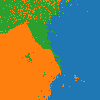

In [10]:
path = 'test.gif'
saveGIF(imgs, path)
showGIF(path)

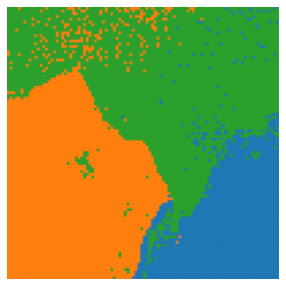

In [11]:
plotCluster(imgs, -1)

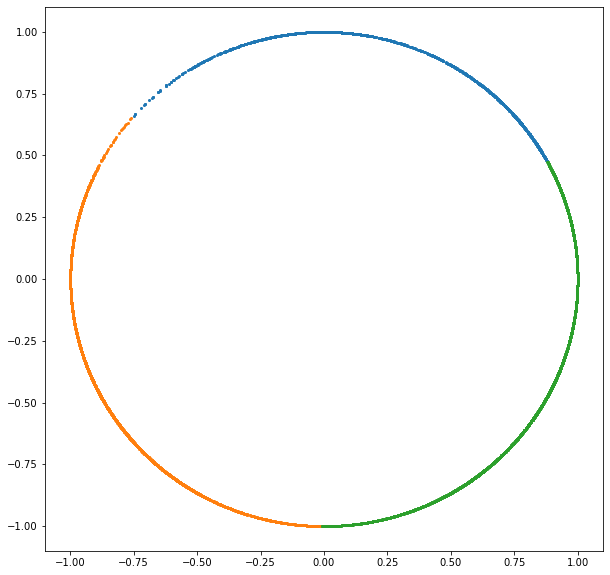

In [12]:
showEigenSpace(T, k, list_labels[-1])

# Ratio Cut

In [13]:
X = readImg('image1.png')
W = computeKernel(X, 5, 5)

In [14]:
k = 3
U = embedding(W, k, 'ratio')

In [15]:
list_labels = kmeans(U, k, initMethod='kmeans++')
imgs = labels2imgs(list_labels, k)

1 0.0021814356285278394
2 0.00028446840999629756
3 5.225900270350224e-05
4 1.6749356324028736e-05
5 0.0
Converged in 5 iterations.


MoviePy - Building file test.gif with imageio.


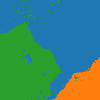

In [16]:
path = 'test.gif'
saveGIF(imgs, path)
showGIF(path)

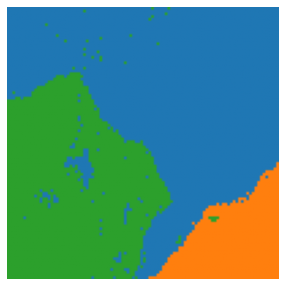

In [17]:
plotCluster(imgs, -1)

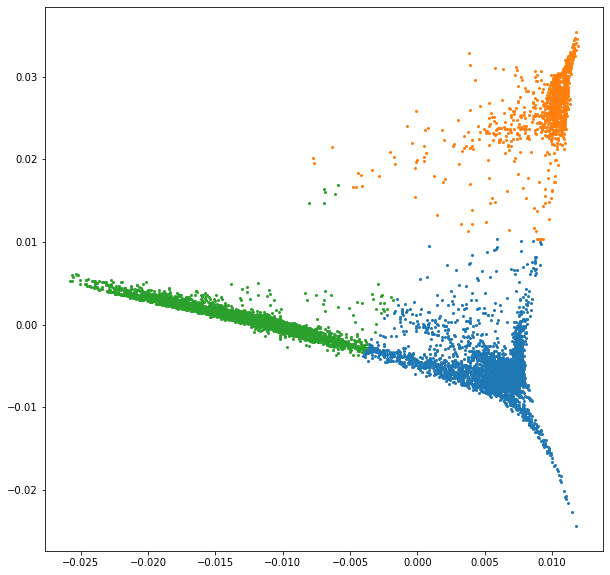

In [18]:
showEigenSpace(U, k, list_labels[-1])